# ROC

This code demonstrates how to use ROC curves to select an optimal classification threshold using a synthetic dataset. Here's what the code does:

1. **Data Preparation and Model Training**
   - Creates a synthetic binary classification dataset
   - Trains a Random Forest classifier
   - Calculates prediction probabilities for test data

2. **ROC Curve Analysis**
   - Generates the ROC curve (True Positive Rate vs False Positive Rate)
   - Calculates Area Under Curve (AUC)

3. **Threshold Selection Methods**
   - Implements two common methods for finding optimal thresholds:
     - **Youden's J statistic**: Maximizes (Sensitivity + Specificity - 1)
     - **Closest point to (0,1)**: Minimizes distance to the perfect classifier point

4. **Performance Evaluation**
   - Compares model performance at different thresholds
   - Calculates key metrics (accuracy, precision, recall, F1 score)
   - Visualizes confusion matrices for different thresholds

5. **Visualization**
   - Plots ROC curve with optimal threshold points
   - Shows how different performance metrics change with threshold values
   - Displays confusion matrices for selected thresholds

When you run this code, you'll see:
- How changing the threshold affects the balance between true positives and false positives
- Which threshold maximizes different performance metrics
- How different optimal threshold selection criteria compare


Comparison of Thresholds:
--------------------------------------------------
Default (0.5):
  threshold: 0.5000
  accuracy: 0.9167
  precision: 0.8662
  recall: 0.9714
  specificity: 0.8688
  f1_score: 0.9158

Youden's J (0.5300):
  threshold: 0.5300
  accuracy: 0.9267
  precision: 0.8986
  recall: 0.9500
  specificity: 0.9062
  f1_score: 0.9236

Closest to (0,1) (0.5500):
  threshold: 0.5500
  accuracy: 0.9267
  precision: 0.9097
  recall: 0.9357
  specificity: 0.9187
  f1_score: 0.9225


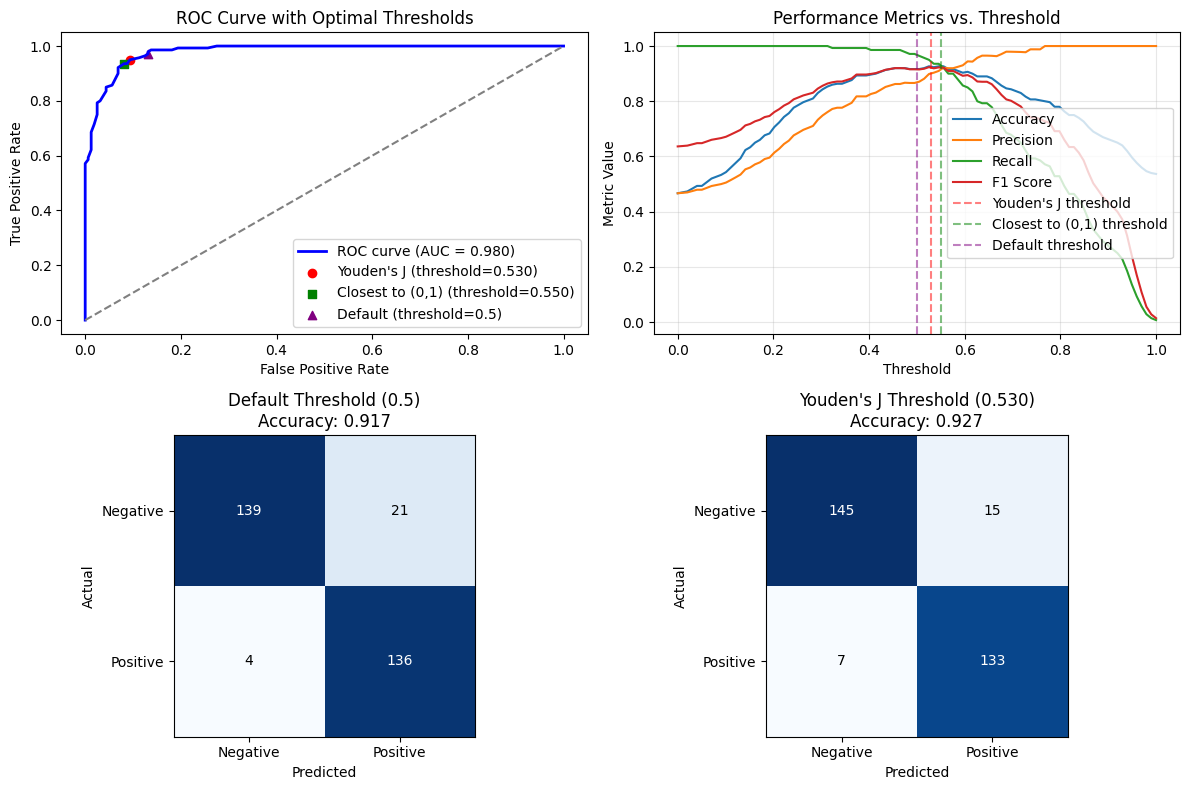

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

# Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                          n_redundant=5, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get probability scores for the positive class
y_scores = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Function to find the optimal threshold based on different criteria
def find_optimal_threshold(fpr, tpr, thresholds):
    """
    Find the optimal threshold using different methods:
    1. Youden's J statistic (maximizes TPR - FPR)
    2. Closest point to (0,1)
    3. Balanced accuracy
    """
    # Youden's J statistic (maximizing TPR - FPR)
    j_scores = tpr - fpr
    j_optimal_idx = np.argmax(j_scores)
    j_optimal_threshold = thresholds[j_optimal_idx]

    # Point closest to (0,1) in the ROC space
    distances = np.sqrt((1-tpr)**2 + fpr**2)
    closest_optimal_idx = np.argmin(distances)
    closest_optimal_threshold = thresholds[closest_optimal_idx]

    return {
        "youden": (j_optimal_threshold, j_optimal_idx),
        "closest": (closest_optimal_threshold, closest_optimal_idx)
    }

# Find optimal thresholds
optimal_thresholds = find_optimal_threshold(fpr, tpr, thresholds)

# Evaluate model at different thresholds
def evaluate_threshold(y_true, y_scores, threshold):
    """Evaluate model performance at a given threshold"""
    y_pred = (y_scores >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    return {
        "threshold": threshold,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "specificity": specificity,
        "f1_score": f1,
        "confusion_matrix": {
            "TP": tp, "FP": fp,
            "TN": tn, "FN": fn
        }
    }

# Evaluate different thresholds
default_results = evaluate_threshold(y_test, y_scores, 0.5)
youden_results = evaluate_threshold(y_test, y_scores, optimal_thresholds["youden"][0])
closest_results = evaluate_threshold(y_test, y_scores, optimal_thresholds["closest"][0])

# Visualize ROC curve and optimal thresholds
plt.figure(figsize=(12, 8))

# Plot ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Mark optimal points
youden_idx = optimal_thresholds["youden"][1]
closest_idx = optimal_thresholds["closest"][1]

plt.scatter(fpr[youden_idx], tpr[youden_idx], marker='o', color='red',
           label=f"Youden's J (threshold={optimal_thresholds['youden'][0]:.3f})")
plt.scatter(fpr[closest_idx], tpr[closest_idx], marker='s', color='green',
           label=f"Closest to (0,1) (threshold={optimal_thresholds['closest'][0]:.3f})")

# Default threshold of 0.5
default_idx = np.abs(thresholds - 0.5).argmin()
plt.scatter(fpr[default_idx], tpr[default_idx], marker='^', color='purple',
           label=f"Default (threshold=0.5)")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Thresholds')
plt.legend(loc="lower right")

# Plot threshold vs various metrics
plt.subplot(2, 2, 2)
metrics_at_thresholds = []
sampled_thresholds = np.linspace(0, 1, 100)
for threshold in sampled_thresholds:
    metrics = evaluate_threshold(y_test, y_scores, threshold)
    metrics_at_thresholds.append(metrics)

# Extract metrics for plotting
accuracies = [m["accuracy"] for m in metrics_at_thresholds]
precisions = [m["precision"] for m in metrics_at_thresholds]
recalls = [m["recall"] for m in metrics_at_thresholds]
f1_scores = [m["f1_score"] for m in metrics_at_thresholds]

plt.plot(sampled_thresholds, accuracies, label='Accuracy')
plt.plot(sampled_thresholds, precisions, label='Precision')
plt.plot(sampled_thresholds, recalls, label='Recall')
plt.plot(sampled_thresholds, f1_scores, label='F1 Score')

# Mark optimal thresholds
plt.axvline(x=optimal_thresholds["youden"][0], color='red', linestyle='--', alpha=0.5,
            label="Youden's J threshold")
plt.axvline(x=optimal_thresholds["closest"][0], color='green', linestyle='--', alpha=0.5,
            label="Closest to (0,1) threshold")
plt.axvline(x=0.5, color='purple', linestyle='--', alpha=0.5, label="Default threshold")

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Threshold')
plt.legend(loc="center right")
plt.grid(True, alpha=0.3)

# Plot the confusion matrices for different thresholds
def plot_confusion_matrix(ax, results, title):
    cm = np.array([
        [results["confusion_matrix"]["TN"], results["confusion_matrix"]["FP"]],
        [results["confusion_matrix"]["FN"], results["confusion_matrix"]["TP"]]
    ])
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

    return im

# Plot confusion matrices for each threshold
plt.subplot(2, 2, 3)
plot_confusion_matrix(plt.gca(), default_results, f"Default Threshold (0.5)\nAccuracy: {default_results['accuracy']:.3f}")

plt.subplot(2, 2, 4)
plot_confusion_matrix(plt.gca(), youden_results, f"Youden's J Threshold ({optimal_thresholds['youden'][0]:.3f})\nAccuracy: {youden_results['accuracy']:.3f}")

plt.tight_layout()

# Print summary of results
print("Comparison of Thresholds:")
print("-" * 50)
print(f"Default (0.5):")
for k, v in default_results.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v:.4f}")

print(f"\nYouden's J ({optimal_thresholds['youden'][0]:.4f}):")
for k, v in youden_results.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v:.4f}")

print(f"\nClosest to (0,1) ({optimal_thresholds['closest'][0]:.4f}):")
for k, v in closest_results.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v:.4f}")

# Show the plots
plt.show()

# Considering different costs

This code demonstrates how to select optimal classification thresholds by considering different cost ratios between false positives (FP) and false negatives (FN). This approach is especially valuable in real-world applications where different types of errors have different consequences.

## Key Concepts

The cost-based threshold selection works on the principle that in many real-world scenarios, false negatives and false positives have different associated costs:

1. **Cost Ratio (CFN/CFP)**: This represents how much more costly a false negative is compared to a false positive
   - Cost ratio > 1: False negatives are more costly
   - Cost ratio < 1: False positives are more costly
   - Cost ratio = 1: Equal costs

2. **Total Cost Function**: For each threshold, we calculate a total cost:
   ```
   Total Cost = (FP Rate) + (Cost Ratio × FN Rate)
   ```

## Example Scenarios

The code examines five different cost scenarios:

1. **Equal Costs (1:1)**: False positives and false negatives are equally costly
2. **FN twice as costly as FP (2:1)**: For example, in medical testing where missing a disease is worse than a false alarm
3. **FN five times as costly as FP (5:1)**: For critical scenarios like cancer detection where missing a case is extremely serious
4. **FP twice as costly as FN (1:2)**: For situations where false alarms are more problematic
5. **FP five times as costly as FN (1:5)**: For scenarios where false alarms are extremely costly

## Results Interpretation

When you run this code, you'll notice:

1. **Threshold Shifts**: As the cost ratio increases (making FNs more costly), the optimal threshold decreases to catch more positive cases, even at the expense of more false positives
2. **ROC Position**: The points on the ROC curve move upward and rightward as FNs become more costly (higher sensitivity, lower specificity)
3. **Confusion Matrix Changes**: The balance between FP and FN errors shifts based on the cost ratio

## Real-World Applications

This approach is particularly useful in:

- **Medical diagnosis**: Where missing a disease (FN) might be life-threatening vs. the cost of additional testing for false alarms (FP)
- **Fraud detection**: Where the cost of missing fraud (FN) vs. the cost of investigating legitimate transactions (FP) has financial implications
- **Predictive maintenance**: Where the cost of missing a failure (FN) vs. unnecessary maintenance (FP) affects operational costs

This method allows you to align your model's decision threshold with your business or application's specific cost structure, rather than using arbitrary threshold values like 0.5.


Comparison of Different Cost-Based Thresholds:
----------------------------------------------------------------------------------------------------
Cost Scenario            Threshold      Sensitivity (TPR)Specificity (TNR)Precision      F1 Score       Accuracy       
----------------------------------------------------------------------------------------------------
Equal Costs (FN = FP)    0.530          0.950          0.906          0.899          0.924          0.927          
FN twice as costly as FP 0.470          0.986          0.863          0.863          0.920          0.920          
FN five times as costly as FP0.470          0.986          0.863          0.863          0.920          0.920          
FP twice as costly as FN 0.560          0.921          0.931          0.921          0.921          0.927          
FP five times as costly as FN0.650          0.793          0.975          0.965          0.871          0.890          


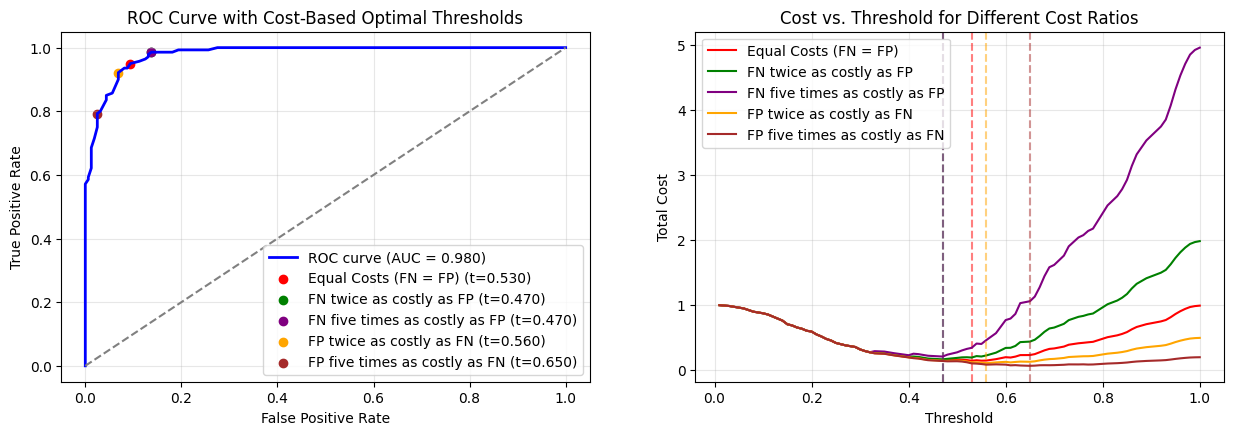

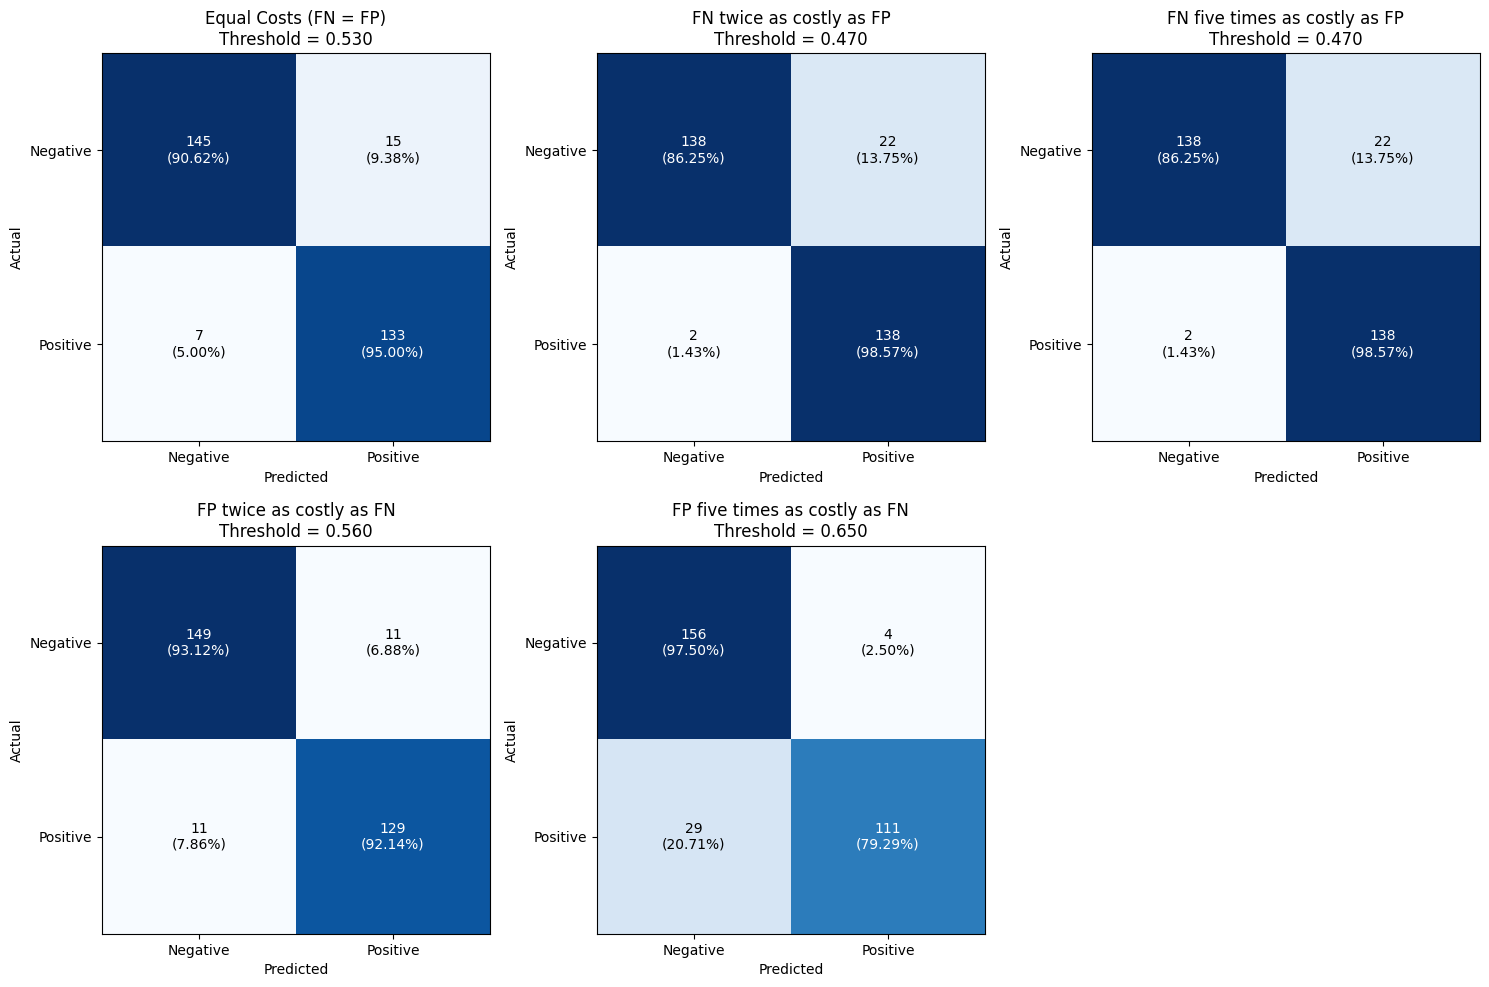

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

# Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                          n_redundant=5, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get probability scores for the positive class
y_scores = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Function to find the optimal threshold based on cost ratio
def find_optimal_cost_threshold(y_true, y_scores, cost_ratio, thresholds=None):
    """
    Find the optimal threshold that minimizes the total cost.

    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_scores : array-like
        Target scores (probability estimates of the positive class)
    cost_ratio : float
        Cost ratio of false negatives to false positives (CFN/CFP)
        e.g., cost_ratio=2 means false negatives are twice as costly as false positives
    thresholds : array-like, optional
        Thresholds to evaluate, if None, 100 evenly spaced thresholds will be used

    Returns:
    --------
    optimal_threshold : float
        The threshold that minimizes the total cost
    total_costs : array-like
        Total cost at each threshold
    evaluated_thresholds : array-like
        The thresholds that were evaluated
    """
    if thresholds is None:
        # Create an array of thresholds to evaluate
        evaluated_thresholds = np.linspace(0.01, 0.99, 100)
    else:
        evaluated_thresholds = thresholds

    total_costs = []

    n_samples = len(y_true)
    n_pos = np.sum(y_true)
    n_neg = n_samples - n_pos

    for threshold in evaluated_thresholds:
        # Make predictions using the threshold
        y_pred = (y_scores >= threshold).astype(int)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate costs
        # Cost of false positives (normalized by the number of negatives)
        cost_fp = fp / n_neg if n_neg > 0 else 0
        # Cost of false negatives (normalized by the number of positives)
        cost_fn = fn / n_pos if n_pos > 0 else 0

        # Calculate total cost
        # FN costs are weighted by the cost ratio
        total_cost = cost_fp + cost_ratio * cost_fn

        total_costs.append(total_cost)

    # Find the threshold that minimizes the total cost
    optimal_idx = np.argmin(total_costs)
    optimal_threshold = evaluated_thresholds[optimal_idx]

    return optimal_threshold, np.array(total_costs), evaluated_thresholds

# Define different cost scenarios
cost_scenarios = {
    "Equal Costs (FN = FP)": 1.0,
    "FN twice as costly as FP": 2.0,
    "FN five times as costly as FP": 5.0,
    "FP twice as costly as FN": 0.5,
    "FP five times as costly as FN": 0.2
}

# Find optimal thresholds for each cost scenario
optimal_cost_thresholds = {}
for name, cost_ratio in cost_scenarios.items():
    opt_threshold, costs, eval_thresholds = find_optimal_cost_threshold(
        y_test, y_scores, cost_ratio, thresholds
    )
    optimal_cost_thresholds[name] = {
        "threshold": opt_threshold,
        "costs": costs,
        "eval_thresholds": eval_thresholds
    }

# Find threshold indices on the ROC curve for visualization
def find_closest_threshold_idx(thresholds, target_threshold):
    return np.abs(thresholds - target_threshold).argmin()

threshold_indices = {}
for name, result in optimal_cost_thresholds.items():
    threshold_indices[name] = find_closest_threshold_idx(thresholds, result["threshold"])

# Create visualization
plt.figure(figsize=(15, 10))

# Plot ROC curve with optimal thresholds
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Colors for different cost scenarios
colors = ['red', 'green', 'purple', 'orange', 'brown']

# Mark optimal points for different cost scenarios
for i, (name, idx) in enumerate(threshold_indices.items()):
    plt.scatter(fpr[idx], tpr[idx], marker='o', color=colors[i],
               label=f"{name} (t={optimal_cost_thresholds[name]['threshold']:.3f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Cost-Based Optimal Thresholds')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Plot cost curves
plt.subplot(2, 2, 2)
for i, (name, result) in enumerate(optimal_cost_thresholds.items()):
    plt.plot(result["eval_thresholds"], result["costs"], color=colors[i], label=f"{name}")
    plt.axvline(x=result["threshold"], color=colors[i], linestyle='--', alpha=0.5)

plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.title('Cost vs. Threshold for Different Cost Ratios')
plt.legend(loc="best")
plt.grid(alpha=0.3)

# Function to evaluate and plot confusion matrices
def plot_confusion_matrices(y_true, y_scores, cost_scenarios, optimal_thresholds):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (name, cost_ratio) in enumerate(cost_scenarios.items()):
        if i >= len(axes):
            break

        threshold = optimal_thresholds[name]["threshold"]
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        # Compute normalized confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Display confusion matrix
        im = axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[i].set_title(f"{name}\nThreshold = {threshold:.3f}")

        # Add class labels
        axes[i].set_xticks([0, 1])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticklabels(['Negative', 'Positive'])
        axes[i].set_yticklabels(['Negative', 'Positive'])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

        # Add text annotations
        for r in range(2):
            for c in range(2):
                axes[i].text(c, r, f"{cm[r, c]}\n({cm_norm[r, c]:.2%})",
                           ha="center", va="center",
                           color="white" if cm[r, c] > cm.max()/2 else "black")

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    return fig

# Plot confusion matrices for different cost scenarios
plot_confusion_matrices(y_test, y_scores, cost_scenarios, optimal_cost_thresholds)

# Function to calculate and display additional metrics
def calculate_metrics(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate common metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return {
        'Sensitivity (TPR)': sensitivity,
        'Specificity (TNR)': specificity,
        'Precision': precision,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
    }

# Create a table to compare metrics for different cost scenarios
results = {}
for name, data in optimal_cost_thresholds.items():
    threshold = data["threshold"]
    metrics = calculate_metrics(y_test, y_scores, threshold)
    results[name] = {
        'Threshold': threshold,
        **metrics
    }

# Print comparison table
print("\nComparison of Different Cost-Based Thresholds:")
print("-" * 100)
metrics_to_display = ['Threshold', 'Sensitivity (TPR)', 'Specificity (TNR)',
                      'Precision', 'F1 Score', 'Accuracy']

# Print header
print(f"{'Cost Scenario':<25}", end="")
for metric in metrics_to_display:
    print(f"{metric:<15}", end="")
print()
print("-" * 100)

# Print rows
for name, metrics in results.items():
    print(f"{name:<25}", end="")
    for metric in metrics_to_display:
        value = metrics[metric]
        if metric == 'Threshold':
            print(f"{value:<15.3f}", end="")
        else:
            print(f"{value:<15.3f}", end="")
    print()

plt.show()